In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import wfdb

import pyedflib

## Notes

Whats the importance of sleep band identification? 
* expect certain sleep ratios. 
* can be used to find concerns (lots of wake episodes or no REM sleep). 
* sleep should be structured into cycles. more deep sleep early on and more REM later on. 
* Assess: are you getting the cycles and

Indicator of heart disease and alzheimer's, etc.


"bands are not real", but it can give a rough estimation of sleep health




**Document very clearly how we are extracting features from the data**

### Models to Try:

* YASA sleep classifier: https://github.com/raphaelvallat/yasa_classifier
* Phypno1
* *Sleep* https://www.frontiersin.org/articles/10.3389/fninf.2017.00060/full


In [2]:
fp = 'data/edfs/shhs1-200001.edf'

In [3]:
# f.readSignal(0)

In [4]:
# f.getNSamples()#[0]

In [5]:
file_name = fp
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sig = []
for i in np.arange(n):
        sig.append(f.readSignal(i))

f.close()

sigs = dict(zip(signal_labels,sig))

In [8]:
sigs['EEG(sec)'].size

4065000

In [10]:
sigs

{'SaO2': array([9.53124285e+01, 9.53124285e+01, 9.53124285e+01, ...,
        1.52590219e-03, 1.52590219e-03, 1.52590219e-03]),
 'H.R.': array([7.73441672e+01, 7.73441672e+01, 7.73441672e+01, ...,
        3.81475547e-03, 3.81475547e-03, 3.81475547e-03]),
 'EEG(sec)': array([  -4.41176471,    5.39215686,    2.45098039, ...,   16.17647059,
         -14.21568627, -123.03921569]),
 'ECG': array([0.03431373, 0.03431373, 0.03431373, ..., 0.05392157, 0.06372549,
        0.01470588]),
 'EMG': array([12.62254902,  3.79901961, -3.55392157, ..., 14.58333333,
        31.25      , 14.09313725]),
 'EOG(L)': array([  28.92156863,   17.15686275,   25.        , ..., -124.01960784,
         125.        ,   25.98039216]),
 'EOG(R)': array([  12.25490196,    1.47058824,   10.29411765, ..., -124.01960784,
         125.        ,   32.84313725]),
 'EEG': array([ -2.45098039,   1.47058824,  -9.31372549, ...,  29.90196078,
        125.        ,  69.11764706]),
 'THOR RES': array([ 0.20784314,  0.20784314,  0.15

In [9]:
sigs['EEG'].size

4065000

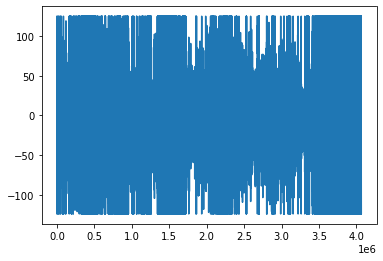

In [12]:
plt.plot(sigs['EEG(sec)'])

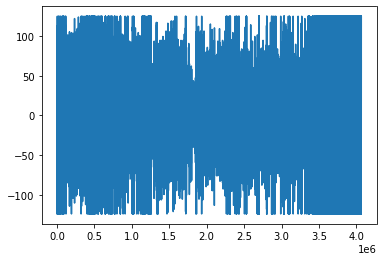

In [11]:
plt.plot(sigs['EEG'])

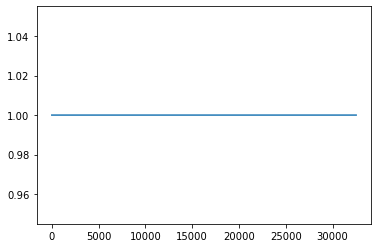

In [14]:
plt.plot(sigs['LIGHT'])

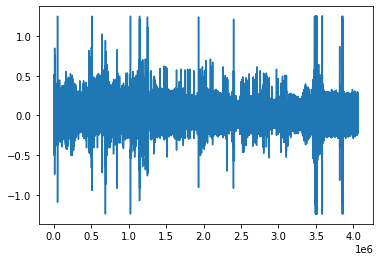

In [9]:
plt.plot(sigs['ECG'])

## GOAL:
* can we improve on EEG metrics using other cardiovascular features. metric: classifier accuracy
* instead: can we classify sleep stages


sources:
* https://www.frontiersin.org/articles/10.3389/fninf.2017.00060/full
* https://elifesciences.org/articles/70092
* https://dash.harvard.edu/handle/1/34492264

write how these sources are different from each other and how ours is different from them


google search: 'open source sleep package for eeg data'

Notes:

* Frequency band discrimination
* slow band sleep?
* good algorithms approach 80% agreement with human
* break into bands (rem, sstage1, stage2, etc)
* Fast Fourier transform (use binning)
    * power per band as a feature?
* avg heartrate per FFT range
* avg distance from perfect metronome (heartbeat)


* start with EEG, then see if adding heart data can be useful

* find packages to classify sleep stages


Questions:
* what bins should we use?
    * The alpha rhythm is typically recorded in awake subjects with their eyes closed. By definition, the frequency of the alpha rhythm is 8–13 Hz, with an amplitude that is typically 10–50 mV. Lower-amplitude beta activity is defined by frequencies of 14–60 Hz and is indicative of mental activity and attention. The theta and delta waves, which are characterized by frequencies of 4–7 Hz and less than 4 Hz, respectively, imply drowsiness, sleep, or one of a variety of pathological conditions (these slo
    * could also look into other bands that are unconventional
    
    
Down scaling data using time series analysis

DSMLP Size 10s of GB
GPU at least 1: 
8 cores cpu:
64GB RAM:

In [7]:
sigs = dict(zip(signal_labels,sig))

In [16]:
sigs['EEG']

array([ -2.45098039,   1.47058824,  -9.31372549, ...,  29.90196078,
       125.        ,  69.11764706])

In [31]:
sigs

{'SaO2': array([9.53124285e+01, 9.53124285e+01, 9.53124285e+01, ...,
        1.52590219e-03, 1.52590219e-03, 1.52590219e-03]),
 'H.R.': array([7.73441672e+01, 7.73441672e+01, 7.73441672e+01, ...,
        3.81475547e-03, 3.81475547e-03, 3.81475547e-03]),
 'EEG(sec)': array([  -4.41176471,    5.39215686,    2.45098039, ...,   16.17647059,
         -14.21568627, -123.03921569]),
 'ECG': array([0.03431373, 0.03431373, 0.03431373, ..., 0.05392157, 0.06372549,
        0.01470588]),
 'EMG': array([12.62254902,  3.79901961, -3.55392157, ..., 14.58333333,
        31.25      , 14.09313725]),
 'EOG(L)': array([  28.92156863,   17.15686275,   25.        , ..., -124.01960784,
         125.        ,   25.98039216]),
 'EOG(R)': array([  12.25490196,    1.47058824,   10.29411765, ..., -124.01960784,
         125.        ,   32.84313725]),
 'EEG': array([ -2.45098039,   1.47058824,  -9.31372549, ...,  29.90196078,
        125.        ,  69.11764706]),
 'THOR RES': array([ 0.20784314,  0.20784314,  0.15

In [10]:
import pywt

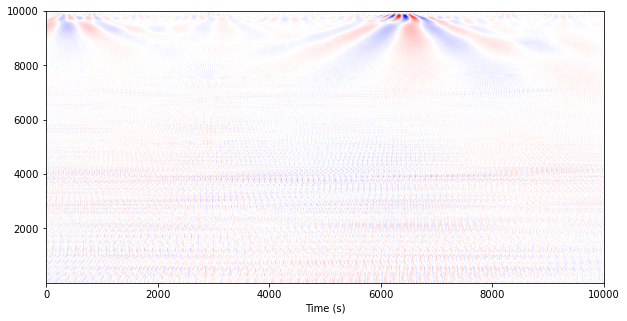

In [15]:
sample_len = 10000
offset = 5000
# pywt.scale2frequency("morl", 1)/1
cwtmatr, freqs = pywt.cwt(
    sigs['ECG'][offset:offset+sample_len], 
    scales=np.arange(1, sample_len+1), 
    wavelet = "morl",
    method= 'conv'
)
plt.figure(figsize=(10, 5))
plt.imshow(cwtmatr, extent=[0, sample_len, 1, sample_len+1], cmap='bwr', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

plt.xlabel('Time (s)')
# plt.imshow(cwtmatr, extent=[-1, 1, 1, 30], cmap='PRGn', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

## Model

In [ ]:
from sklearn.linear_model import Ridge

In [4]:
clf = Ridge()